In [4]:
import pandas as pd
import os
init_dir_path = str(os.getcwd())  # find current working directory

dir_path = init_dir_path+"/btc-price1m"
df = pd.read_csv(dir_path+"/data.csv", header=0, parse_dates=True)
df = df.drop(["Symbol","High","Low", "Volume BTC", "Volume USD"], axis=1)

In [5]:
df[["Date","Time"]] = df["Date"].str.split(" ", expand=True)#Split date and time data
df=df[["Timestamp","Date","Time", "Open","Close"]]
df["Time"] = df["Time"].str[:-3]#remove the redundant seconds data

In [6]:
df.to_csv(dir_path+"/skimmed_data.csv", index=False)

In [16]:
from __future__ import print_function

import datetime
import pickle
import warnings
from sklearn.preprocessing import StandardScaler
from hmmlearn.hmm import GaussianHMM
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
from matplotlib import cm, pyplot as plt
from matplotlib.dates import HourLocator, MinuteLocator
import numpy as np
import pandas as pd
import seaborn as sns
from __future__ import print_function

from collections import deque

import numpy as np

# from qstrader.price_parser import PriceParser
# from qstrader.event import (SignalEvent, EventType)
# from qstrader.strategy.base import AbstractStrategy
# from qstrader.event import OrderEvent
# from qstrader.risk_manager.base import AbstractRiskManage

Reference article: [quantstart.com](https://www.quantstart.com/articles/market-regime-detection-using-hidden-markov-models-in-qstrader/)

Github repo: [qstrader](https://github.com/mhallsmoore/qstrader)

The obtain_prices_df function opens up the CSV file of the saved BTC data into a Pandas DataFrame. It then calculates the percentage returns of the adjusted closing prices and truncates the ending date to the desired final training period. Calculating the percentage returns introduces NaN values into the DataFrame, which are then dropped in place:

In [ ]:
def obtain_prices_df(df_path, start_date):
    """
    Use the prices DataFrame ,
    filter by the end date and calculate the 
    percentage returns.
    """
    df = pd.read_csv(df_path, header=0, parse_dates=True)
    new_df = df[df["Date"] >= start_date]
    new_df["Returns"] = (df["Close"]-df["Open"])/df["Open"]*100
    new_df["volatility"] = new_df["Returns"].rolling(window=5).std()#can employ more sophisticated calculations
    scaler = StandardScaler()
    new_df[["Returns", "volatility"]] = scaler.fit_transform(new_df[["Returns", "volatility"]])#normalizing values for model convergence
    return new_df

The following function, plot_in_sample_hidden_states, is not strictly necessary for training purposes. It has been modified from the hmmlearn tutorial file found in the documentation.

The code takes the model along with the prices DataFrame and creates a subplot, one plot for each hidden state generated by the model. Each subplot displays the adjusted closing price masked by that particular hidden state/regime. This is useful to see if the HMM is producing "sane" states

In [10]:
def plot_in_sample_hidden_states(hmm_model, df, features):
    """
    Plot the adjusted closing prices masked by 
    the in-sample hidden states as a mechanism
    to understand the market regimes.
    """
    # Predict the hidden states array
    rets = df[features]
    hidden_states = hmm_model.predict(rets)
    # Create the correctly formatted plot
    fig, axs = plt.subplots(
        hmm_model.n_components, 
        sharex=True, sharey=True
    )
    colours = cm.rainbow(
        np.linspace(0, 1, hmm_model.n_components)
    )
    for i, (ax, colour) in enumerate(zip(axs, colours)):
        mask = hidden_states == i
        ax.plot(
            df.index[mask], 
            df["Close"][mask], 
            ".", linestyle='none', 
            c=colour
        )
        ax.set_title(f"Hidden State #{i}")
        # ax.xaxis.set_major_locator(HourLocator(interval=1))  # Major ticks at every hour
        # ax.xaxis.set_minor_locator(MinuteLocator(interval=15))  # Minor ticks every 15 minutes
        ax.grid(True)
    plt.show()

In [20]:
def switch_hidden_states(model, hidden_states, rets):    
    #vol_per_state = []
    return_per_state = []
    for state in range(model.n_components):
        #state_vols = vol[hidden_states == state]
        state_rets = rets[hidden_states == state]
        state_return = np.mean(state_rets)
        #state_vol = np.mean(state_vols)
        #vol_per_state.append(state_vol)
        return_per_state.append(state_return)
    if (return_per_state[0]<return_per_state[1]): #force hidden state 0 to be always high return 
        model.startprob_ = model.startprob_[::-1]
        model.transmat_ = model.transmat_[::-1, ::-1]
         # Swap means and covariances to maintain consistency
        model.means_ = model.means_[::-1]
        model.covars_ = model.covars_[::-1]
    return model

Need to edit this code below to get minute-by-minute analysis working. Right now, EM doesn't converge over past data (60 minutes), let alone for 3 days. Still working on it...

In [ ]:
#Code block to implement rolling minute-by-minute analysis
# hours = 1#number of days to look back
# window_size = hours*60 
# training_queue = deque(maxlen=window_size)
# # Simulating minute-by-minute data stream
# for index, row in new_df.iterrows():
#     # Extract minute data
#     current_time = row["Time"]
#     day = row["Date"]
#     feature_vector = np.array([[row["Returns"], row["volatility"]]])

#     # Add new data to rolling window
#     if not(np.isnan(feature_vector).any()):
#         training_queue.append(feature_vector)

#     # Train when window is full
#     if len(training_queue) == window_size:
#         features = np.vstack(training_queue)
#         # Fit the model to the rolling window
#         model.fit(features)
#         if int(day[-2:])==15 and int(day[5:7])%3==0 and current_time == "10:30":#predict models prices based on the last 3 days
#             ts = new_df[(new_df["Date"] == day)&(new_df["Time"]>="09:00")&(new_df["Time"] <= "10:30")]
#             plot_in_sample_hidden_states(model,ts , ["Returns", "volatility"])# Plot the in sample hidden states closing values
#             print(model.score(features[0,:].reshape(-1, 1)))
#         # Predict hidden states
#         hidden_states = model.predict(features)
#         # Store model score for evaluation
#         model_scores.append(model.score(features))
#         # Switch hidden states if necessary
#         model = switch_hidden_states(model, hidden_states, features[:, 0].reshape(-1, 1))

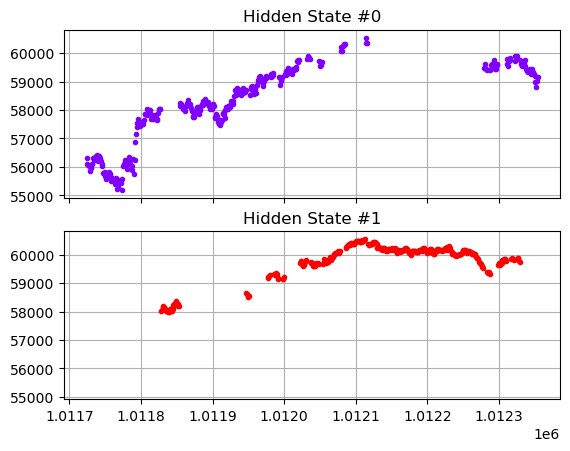

-21698.93048201926


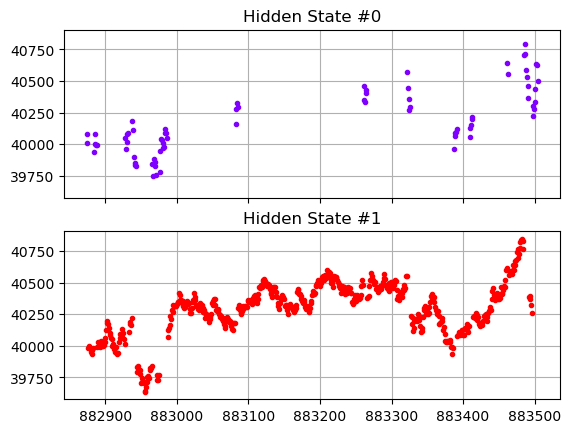

-16767.854166257883


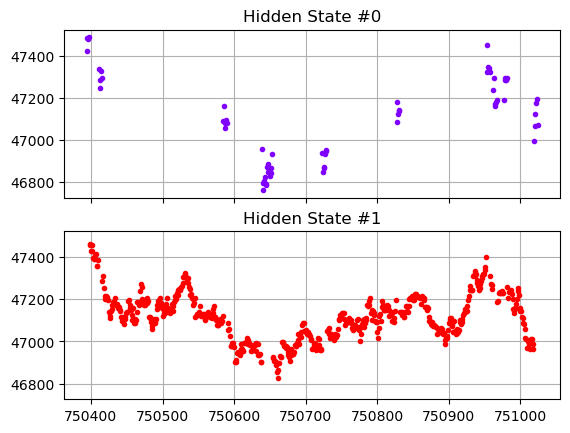

-14716.78855897928


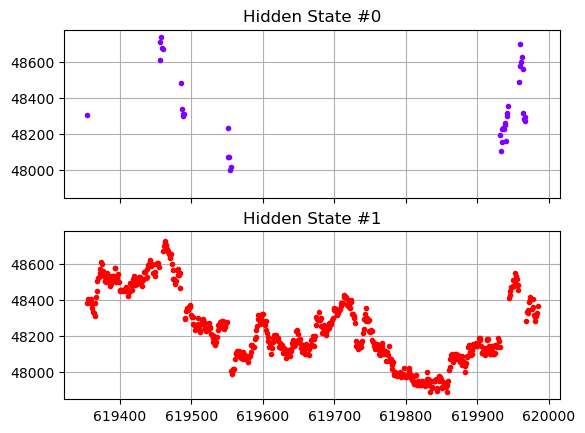

-14971.569809055085


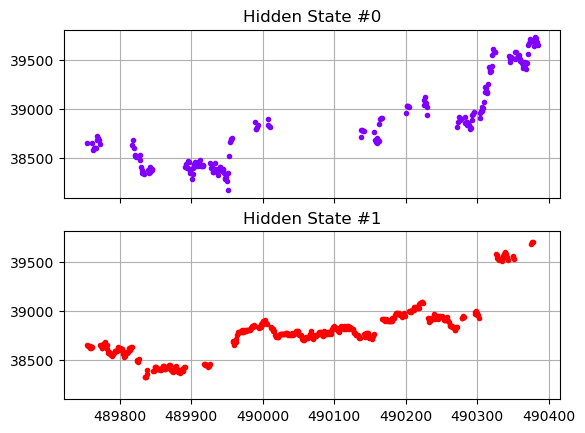

-13490.138427309668


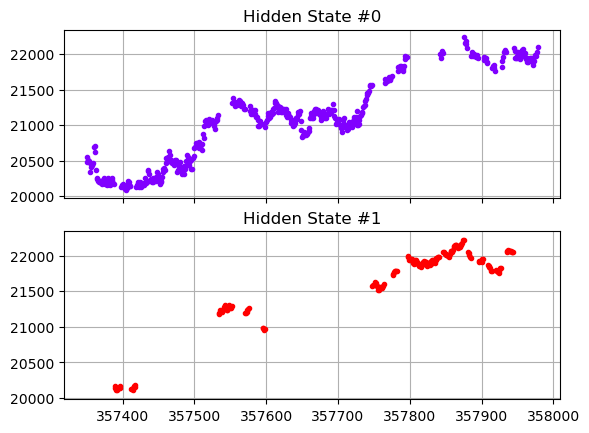

-28049.0396527783


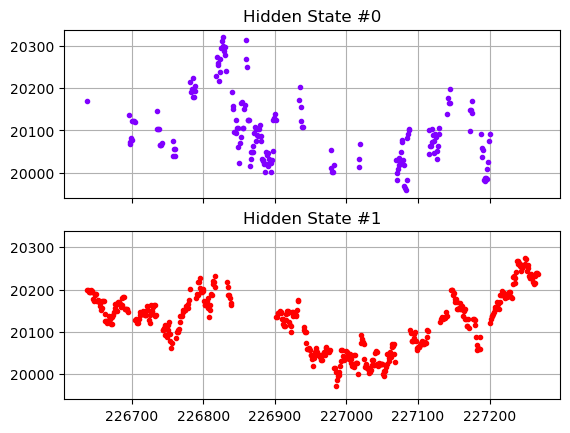

-12619.464973993054


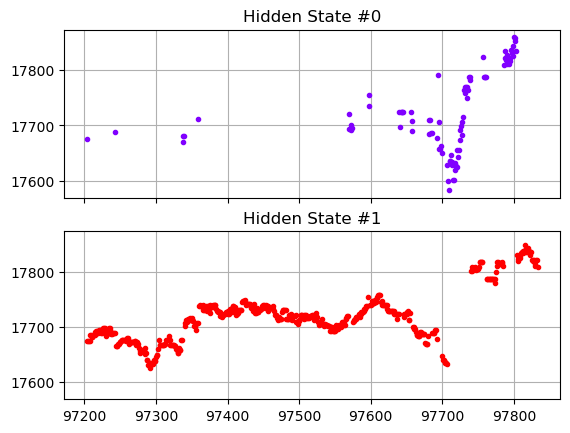

-20708.50477952999


Model is not converging.  Current: 10976.998966408339 is not greater than 10981.212252583793. Delta is -4.213286175454414
Model is not converging.  Current: 7798.771672825377 is not greater than 7809.655150332687. Delta is -10.88347750731009
Model is not converging.  Current: 5934.79966174995 is not greater than 5956.004661554712. Delta is -21.204999804761428
Model is not converging.  Current: 3640.0659754741587 is not greater than 3656.101920627668. Delta is -16.035945153509147
Model is not converging.  Current: 5623.481026381177 is not greater than 5623.482728196989. Delta is -0.0017018158123391913
Model is not converging.  Current: 8486.131969843444 is not greater than 8486.14856272015. Delta is -0.016592876705544768
Model is not converging.  Current: 9180.393255301362 is not greater than 9180.816342176035. Delta is -0.4230868746726628
Model is not converging.  Current: 7419.996421462569 is not greater than 7435.975711043943. Delta is -15.97928958137436
Model is not converging.  Cur

Pickling HMM model...
...HMM model pickled.


In [32]:

# Hides deprecation warnings for sklearn
warnings.filterwarnings("ignore")
# Create the SPY dataframe from the Yahoo Finance CSV
# and correctly format the returns for use in the HMM
csv_filepath = dir_path+"/skimmed_data.csv"
pickle_path = init_dir_path+"/models/hmm_model_btc.pkl"
if not os.path.exists(init_dir_path+"/models"):
    os.makedirs(init_dir_path+"/models")
start_date = "2021-01-01"
new_df = obtain_prices_df(csv_filepath, start_date)
# Create the Gaussian Hidden markov Model and fit it
# to the BTC returns data, outputting a score
model = GaussianHMM(n_components=2, covariance_type="full", n_iter=5000, init_params="", tol=1e-4)
date_range = pd.date_range(start_date, new_df["Date"].iloc[0])
model_scores = []
#code block to implement rolling day-by-day analysis
for day in date_range[15:-15]:
    start = day - datetime.timedelta(days=3)#hyperparameter to be tuned
    day = str(day.date())
    start = str(start.date())
    time_series = new_df[(new_df["Date"]>= start)&(new_df["Date"]<= day)]
    features = time_series[["Returns", "volatility"]].dropna()
    ts = time_series[(time_series["Date"] == day)&(time_series["Time"] <= "10:30")]
    if day >= "2021-01-17" and int(day[-2:])==15 and int(day[5:7])%3==0:#predict models prices based on the last 3 days
        plot_in_sample_hidden_states(model, ts, ["Returns", "volatility"])# Plot the in sample hidden states closing values
        print(model.score(time_series["Returns"].values.reshape(-1, 1)))
    model.fit(features) #fit model to data over past <hyperparameter> days
    hidden_states = model.predict(features)
    model_scores.append(model.score(time_series["Returns"].values.reshape(-1, 1)))

print("Pickling HMM model...")
pickle.dump(model, open(pickle_path, "wb"))
print("...HMM model pickled.")

Code from hereon is all commented and is for the backtesting/active investing setup

In [ ]:
#calculate returns 

# def _store_event(self, event):
#     """
#     Store price event for closing price and adjusted closing price
#     """
#     ticker = event.ticker
#     # If the calc_adj_returns flag is True, then calculate
#     # and store the full list of adjusted closing price
#     # percentage returns in a list
#     if self.calc_adj_returns:
#         prev_adj_close = self.tickers[ticker][
#             "adj_close"
#         ] / PriceParser.PRICE_MULTIPLIER
#         cur_adj_close = event.adj_close_price / PriceParser.PRICE_MULTIPLIER
#         self.tickers[ticker][
#             "adj_close_ret"
#         ] = cur_adj_close / prev_adj_close - 1.0
#         self.adj_close_returns.append(self.tickers[ticker]["adj_close_ret"])
#     self.tickers[ticker]["close"] = event.close_price
#     self.tickers[ticker]["adj_close"] = event.adj_close_price
#     self.tickers[ticker]["timestamp"] = event.time

In [ ]:
# from qstrader.alpha_model.alpha_model import AlphaModel
# from collections import deque

# class MovingAverageCrossAlphaModel(AlphaModel):
#     """
#     A moving average crossover strategy where a short-term moving average
#     crosses over a long-term moving average.
    
#     Attributes:
#     tickers (list): List of ticker symbols.
#     events_queue: Queue of events for managing trading logic.
#     base_quantity (int): The amount of asset to trade.
#     short_window (int): Lookback period for the short moving average.
#     long_window (int): Lookback period for the long moving average.
#     """
    
#     def __init__(
#         self, tickers, events_queue, base_quantity,
#         short_window=10, long_window=30
#     ):
#         self.tickers = tickers
#         self.events_queue = events_queue
#         self.base_quantity = base_quantity
#         self.short_window = short_window
#         self.long_window = long_window
#         self.sw_bars = deque(maxlen=self.short_window)  # Short window bars
#         self.lw_bars = deque(maxlen=self.long_window)   # Long window bars
#         self.bars = 0
#         self.invested = False

#     def __call__(self, dt, asset, state):
#         """
#         Generate alpha signals based on moving average crossovers.
        
#         Parameters:
#         dt (datetime): The current date.
#         asset (str): The asset (ticker symbol) for the strategy.
#         state (BacktestState): The current backtest state, providing access to data.
        
#         Returns:
#         float: The signal indicating whether to go long (1), short (-1), or hold (0).
#         """
#         try:
#             # Retrieve the historical data for the asset
#             prices = state.get_asset_latest_values(asset, 'close', self.long_window)

#             if len(prices) < self.long_window:
#                 return 0.0  # Not enough data for moving average calculation

#             # Update moving averages
#             self.sw_bars.append(prices[-1])
#             self.lw_bars.append(prices[-1])
            
#             # Calculate the short and long moving averages
#             short_ma = np.mean(self.sw_bars)
#             long_ma = np.mean(self.lw_bars)

#             # Generate the trading signal based on moving average crossover
#             if short_ma > long_ma:
#                 if not self.invested:
#                     self.invested = True
#                     return 1.0  # Buy signal (long position)
#                 else:
#                     return 0.0  # No signal if already invested
#             elif short_ma < long_ma:
#                 if self.invested:
#                     self.invested = False
#                     return -1.0  # Sell signal (short position)
#                 else:
#                     return 0.0  # No signal if not invested
#             else:
#                 return 0.0  # No trade when they are equal

#         except Exception as e:
#             print(f"Error in alpha model: {e}")
#             return 0.0  # Default to no signal on error

In [ ]:
# def calculate_signals(self, event):
#     # Applies SMA to first ticker
#     ticker = self.tickers[0]
#     if event.type == EventType.BAR and event.ticker == ticker:
#         # Add latest adjusted closing price to the
#         # short and long window bars
#         price = event.adj_close_price/PriceParser.PRICE_MULTIPLIER
#         self.lw_bars.append(price)
#         if self.bars > self.long_window - self.short_window:
#             self.sw_bars.append(price)

#         # Enough bars are present for trading
#         if self.bars > self.long_window:
#             # Calculate the simple moving averages
#             short_sma = np.mean(self.sw_bars)
#             long_sma = np.mean(self.lw_bars)
#             # Trading signals based on moving average cross
#             if short_sma > long_sma and not self.invested:
#                 print("LONG: %s" % event.time)
#                 signal = SignalEvent(ticker, "BOT", self.base_quantity)
#                 self.events_queue.put(signal)
#                 self.invested = True
#             elif short_sma < long_sma and self.invested:
#                 print("SHORT: %s" % event.time)
#                 signal = SignalEvent(ticker, "SLD", self.base_quantity)
#                 self.events_queue.put(signal)
#                 self.invested = False
#         self.bars += 1

In [ ]:
# class RegimeHMMRiskManager(AbstractRiskManager):
#     """
#     Utilises a previously fitted Hidden Markov Model 
#     as a regime detection mechanism. The risk manager
#     ignores orders that occur during a non-desirable
#     regime.

#     It also accounts for the fact that a trade may
#     straddle two separate regimes. If a close order
#     is received in the undesirable regime, and the 
#     order is open, it will be closed, but no new
#     orders are generated until the desirable regime
#     is achieved.
#     """
#     def __init__(self, hmm_model):
#         self.hmm_model = hmm_model
#         self.invested = False

In [ ]:
# def refine_orders(self, portfolio, sized_order):
#     """
#     Uses the Hidden Markov Model with the percentage returns
#     to predict the current regime, either 0 for desirable or
#     1 for undesirable. Long entry trades will only be carried
#     out in regime 0, but closing trades are allowed in regime 1.
#     """
#     # Determine the HMM predicted regime as an integer
#     # equal to 0 (desirable) or 1 (undesirable)
#     price_handler = portfolio.price_handler
#     regime = self.determine_regime(
#         price_handler, sized_order
#     )
#     action = sized_order.action
#     # Create the order event, irrespective of the regime.
#     # It will only be returned if the correct conditions 
#     # are met below.
#     order_event = OrderEvent(
#         sized_order.ticker,
#         sized_order.action,
#         sized_order.quantity
#     )
#     # If in the desirable regime, let buy and sell orders
#     # work as normal for a long-only trend following strategy
#     if regime == 0:
#         if action == "BOT":
#             self.invested = True
#             return [order_event]
#         elif action == "SLD":
#             if self.invested == True:
#                 self.invested = False
#                 return [order_event]
#             else:
#                 return []
#     # If in the undesirable regime, do not allow any buy orders
#     # and only let sold/close orders through if the strategy
#     # is already invested (from a previous desirable regime)
#     elif regime == 1:
#         if action == "BOT":
#             self.invested = False
#             return []
#         elif action == "SLD":
#             if self.invested == True:
#                 self.invested = False
#                 return [order_event]
#             else:
#                 return []